In [11]:
import numpy as np
import pandas as pd
from helpers import *

In [12]:
def S1(x,gamma):
    """
    Calcule l’estimateur de McCulloch (ou un vecteur de 4 nombres)
    qui correspondent aux estimations de (alpha, beta, gamma, delta) à partir de x.
    """
    # Chercher l'estimateur de McCulloch pour alpha, beta, gamma, delta
    # (voir le papier de McCulloch, 1986)
    q = np.quantile(x, [0.05, 0.25, 0.5, 0.75, 0.95])
    alpha_hat = (q[4]-q[0])/(q[3]-q[1])
    beta_hat = (q[4]+q[0]-2*q[2])/(q[4]-q[0])
    gamma_hat = (q[3]-q[1])/gamma
    delta_hat = np.mean(x)
    return np.array([alpha_hat, beta_hat, gamma_hat, delta_hat])

ABC- reject

In [22]:
def prior_sample(n_samples):
    """
    Tire n_samples vecteurs theta selon la loi a priori.
    Chaque theta est un vecteur (alpha, beta, gamma, delta) avec :
        - alpha ~ Uniform(1.1, 2)
        - beta ~ Uniform(-1, 1)
        - gamma ~ Lognormal(0, 0.1)
        - delta ~ Normal(0, 1.5)
    
    Retourne un tableau numpy de forme (n_samples, 4).
    """
    alpha = np.random.uniform(1.1, 2.0, size=n_samples)
    beta  = np.random.uniform(-1.0, 1.0, size=n_samples)
    gamma = np.random.lognormal(mean=0, sigma=0.1, size=n_samples)
    delta = np.random.normal(loc=0.0, scale=1.5, size=n_samples)

    return np.stack((alpha, beta, gamma, delta), axis=1)

def dist(s_sim, s_obs):
    """  L2 norm"""
    return np.linalg.norm(s_sim - s_obs, ord=2)

def newstat(statistic, x, gamma = 1):
    if statistic == "s1":
        return S1(x, gamma)
    else:
        return stat(statistic, x)

def abc_rejection(y_obs, N, n_sim, epsilon, statistic,gamma= 1):
    """
    y_obs: données observées
    N: nombre de tirages de la prior à considérer
    n_sim: taille de l'échantillon simulé pour chaque theta
    epsilon: seuil ABC

    Sortie: liste (ou np.array) des theta acceptés
    """

    # 1) Calculer la statistique résumée pour les données observées
    s_obs = newstat(statistic,y_obs, gamma=gamma)

    # 2) Échantillonner N valeurs de theta selon la prior
    thetas = prior_sample(N)

    # Tableau pour stocker les thetas acceptés
    accepted_thetas = []

    for i in range(N):
        theta_i = thetas[i]
        # 3) Simuler un échantillon x_i
        x_i = simulation_alpha_stable_rqmc(theta_i[0],theta_i[1], theta_i[2], theta_i[3], n_sim)
        # 4) Calculer la statistique résumée sur x_i
        s_i = newstat(statistic,x_i, gamma=gamma)
        # 5) Calculer la distance et comparer à epsilon
        dista = dist(s_i, s_obs)
        if dista < epsilon:
            accepted_thetas.append(theta_i)

    return np.array(accepted_thetas)


Tests

In [ ]:
def descriptive(theta_posterior):
    #do some descriptive statistics 
    df = pd.DataFrame(theta_posterior, columns=["alpha", "beta", "gamma", "delta"])

    df.hist(bins=50, figsize=(10, 6))
    plt.suptitle("Marginal posterior distributions" )
    plt.show()

    mean = np.mean(theta_posterior, axis=0)
    ci95 = np.percentile(theta_posterior, [2.5, 97.5], axis=0)

    for name, m, ci in zip(["alpha", "beta", "gamma", "delta"], mean, ci95.T):
        print(f"{name:6s} mean = {m:.3f},  95% CI = [{ci[0]:.3f}, {ci[1]:.3f}]")

In [15]:
alpha = 1.7
beta = 0.5
gamma = 1.0
delta = 0.0
np.random.seed(1234)#just to reproduce same results (aligned with our report)
y_obs=simulation_alpha_stable_rqmc(alpha, beta, gamma, delta, n=4096)

32.6 % accepted for s1


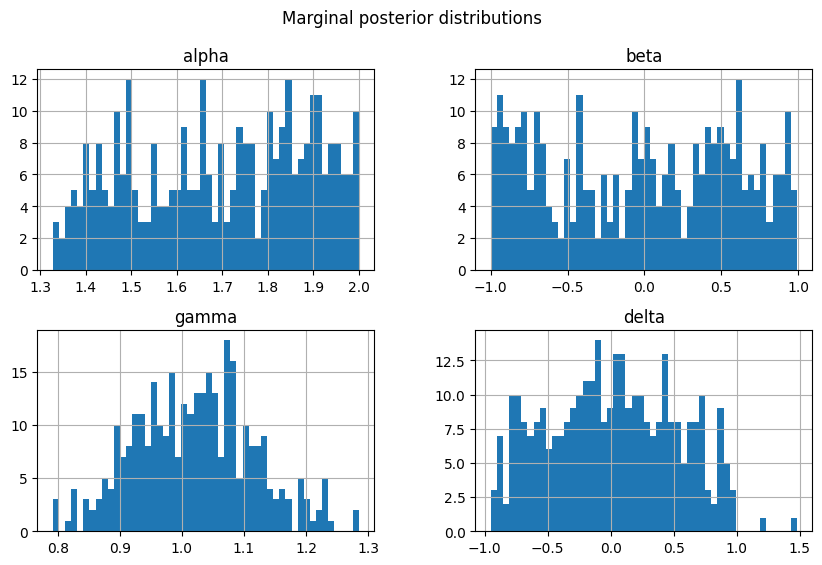

alpha  mean = 1.696,  95% CI = [1.368, 1.988]
beta   mean = -0.021,  95% CI = [-0.966, 0.945]
gamma  mean = 1.021,  95% CI = [0.843, 1.223]
delta  mean = 0.013,  95% CI = [-0.856, 0.915]


In [16]:
#s1-----------------------
theta_s1= abc_rejection(y_obs,1000, 4096, 1,"s1", gamma=gamma)
print(100*len(theta_s1)/1000,"% accepted for s1")
descriptive(theta_s1)

In [ ]:
#s2-----------------------
theta_s2= abc_rejection(y_obs,1000, 4096, 1,"s2", gamma=gamma)
print(100*len(theta_s2)/1000,"% accepted for s2")
descriptive(theta_s2)

In [ ]:
#s3-----------------------
theta_s3= abc_rejection(y_obs,1000, 4096, 1,"s3", gamma=gamma)
print(100*len(theta_s3)/1000,"% accepted for s3")
descriptive(theta_s3)

In [ ]:
#s4-----------------------
theta_s4= abc_rejection(y_obs,1000, 4096, 1,"s4", gamma=gamma)
print(100*len(theta_s4)/1000,"% accepted for s4")
descriptive(theta_s4)